# MULTI-MODAL CLASSIFICATION.

**Jesse Maina**

Predicting multi-modal data by using information about relationships between features across samples in each modality

### Importing the data
Panda's `pd.read_csv` method imports the RNA and ADT data into a dataframe. I also generate training & testing subsets from the whole training data, for model comparison purposes before building the final model for Kaggle submission. I use a subset of 3000 samples as train data and the remaining 1000 samples as test data.

In [ ]:
import pandas as pd
import numpy as np

train_rna = pd.read_csv("/content/drive/MyDrive/Masters/CIS 678/cis678-challenge-2-prediction/training_set_rna.csv",index_col=0).values
train_adt = pd.read_csv("/content/drive/MyDrive/Masters/CIS 678/cis678-challenge-2-prediction/training_set_adt.csv",index_col=0).values
test_rna= pd.read_csv("/content/drive/MyDrive/Masters/CIS 678/cis678-challenge-2-prediction/test_set_rna.csv",index_col=0).values


In [ ]:
train_rna_subset = train_rna[:,:3000]
train_adt_subset = train_adt[:,:3000]
test_rna_subset = train_rna[:,3000:]
test_adt_subset = train_adt[:,3000:]
train_adt_subset.shape,train_rna_subset.shape, test_rna_subset.shape, test_adt_subset.shape

((25, 3000), (639, 3000), (639, 1000), (25, 1000))

### Build a Linear Regression Model
Next, I build a linear regression model using Ordinary Least Squares on each of the ADT proteins and evaluate the result against pearson correlation.
The least squares formula is given by:
$$x = \left(A^\intercal A\right)^{-1} A^\intercal y $$
which obtains the unweighted coefficients of each ADT protein.


In [ ]:
A = train_rna_subset.T
actual = test_adt_subset.flatten()
predicted = []

for y in train_adt_subset:
  y=y[:,np.newaxis] # y[i] 0<i<24
  x = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y) # ordianry least square
  predicted.extend((np.sum(x*test_rna_subset,axis=0)).flatten()) # Ax = y_predicted


pearson_corr = np.corrcoef(actual,predicted)[0,1]
f"Linear Regression correlation: {pearson_corr}"



'Linear Regression correlation: 0.7970374809107968'

Adding an intercept term to the model raises the correlation slightly.


In [ ]:
predicted = []
A = np.hstack((np.full((3000,1),1),train_rna_subset.T))
for y in train_adt_subset:
  y=y[:,np.newaxis]
  x = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y)#least squares
  predicted.extend((np.sum(x[1:]*test_rna_subset,axis=0)+x[0]).flatten())

f"Linear Regression correlation with intercept term: {np.corrcoef(actual,predicted)[0,1]}"


'Linear Regression correlation with intercept term: 0.7983223905150205'

### Predicting using Non-negative Matrix Factorization
Nmf is used to obtain a matrix `W`, which contains the features embedding and matrix `H` which contains the sample embeddings on the train data then we project the results to the test RNA to get test sample embeddings then predict the test ADT.

In [ ]:
import numpy as np

def nmf(X, k, max_iter=1000,verbose=True):
    if verbose:
      print(f"Doing k = {k}")
    # Randomly initialize W and initialize H with zeros
    np.random.seed(42)
    W = np.random.rand(X.shape[0], k)
    H = np.zeros((k, X.shape[1])) + 1e-15 #add epsilon to prevent division by zero

    for i in range(max_iter):

        #Update H and W alternatingly using ALS
        H *= np.dot(W.T, X) / (np.dot(np.dot(W.T, W), H))

        W *= np.dot(X, H.T) / (np.dot(W, np.dot(H, H.T)))

    return W, H

def get_H_test(A, W, k, num_iterations=100):
    H_hat = np.random.rand(k, A.shape[1])#randomly initialize H with the correct dimension

    for i in range(num_iterations):
        H_hat = np.linalg.lstsq(W.T.dot(W), W.T.dot(A), rcond=None)[0]#get least square update
        H_hat[H_hat < 0] = 0 #non-negativity constraint
        #Do not update W because it's already non-negative

    return H_hat


A=np.vstack((train_adt_subset,train_rna_subset))

nmf_cors = dict()

#randomly loop values to find an optimal rank
for k in range(10,301,10):
  W, H = nmf(A, k,verbose=False)
  H_test = get_H_test(test_rna_subset,W[25:],k)
  adt_predictions = W[:25].dot(H_test)
  nmf_cors[k] = np.corrcoef(adt_predictions.flatten(),test_adt_subset.flatten())[0,1]

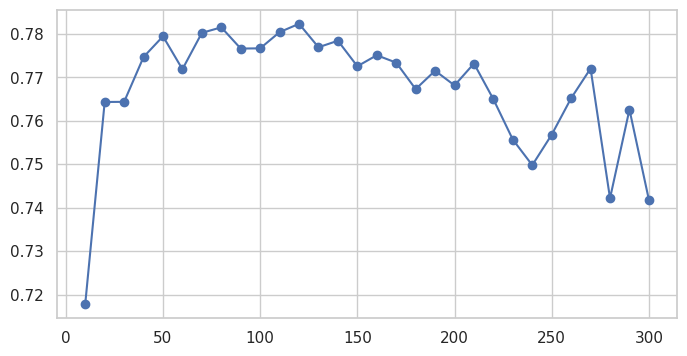

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette(None)
plt.figure(figsize=(8,4))

plt.plot(nmf_cors.keys(),nmf_cors.values(),marker="o")

In [ ]:
f"highest NMF:{sorted(nmf_cors.values())[-1]}"

'highest NMF:0.7823113831817684'

The highest correlation nmf achieves is 0.78, which means linear regression is a better performing model.

### Exploring Other Regression Models.
There is a ton of regression models. We chose some of the top performing ones to see how they stack up against linear regression.

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet,SGDRegressor,BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr,uniform,expon
from time import process_time

def test_estimators(estimators,verbose=False):
  results = {}
  ground_truths = test_adt_subset.flatten()
  # Fit models and calculate Pearson correlation
  for estimator_name, estimator in estimators:
    predictions = []
    start = process_time()

    for i,y in enumerate(train_adt_subset):
      if verbose:
        print(f"Evaluating {estimator}, iteration {i+1}")
      estimator.fit(train_rna_subset.T, y.T)

      y_pred = estimator.predict(test_rna_subset.T)
      predictions.extend(y_pred)

    mse = mean_squared_error(ground_truths, predictions)
    correlation, _ = pearsonr(ground_truths, predictions)

    end = process_time()

    results[estimator_name] = {
        'mse': mse,
        "correlation": correlation,
        "time": (end-start)/60
    }
  return results



In [ ]:
estimators = [
      ("LGBMRegressor",LGBMRegressor()),
      ("XGBRegressor",XGBRegressor()),
      ("BayesianRidge",BayesianRidge()),
      ('Ridge', Ridge()),
      ('Lasso', Lasso()),
      ("SVR", SVR()),
      ('ElasticNet', ElasticNet()),
      ('KNeighborsRegressor', KNeighborsRegressor()),
      ('DecisionTreeRegressor', DecisionTreeRegressor()),
      ('GradientBoostingRegressor', GradientBoostingRegressor()),
      ('AdaBoostRegressor', AdaBoostRegressor()),
  ]
results = test_estimators(estimators)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154063
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 639
[LightGBM] [Info] Start training from score 0.799801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154063
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 639
[LightGBM] [Info] Start training from score 0.899641
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154063
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 639
[LightGBM] [Info] Sta

In [ ]:
for estimator_name, result in results.items():
    print("*"*30)
    print(f"{estimator_name}:")
    print(f"Mean Squared Error: {result['mse']:.3f}")
    print(f"Pearson Correlation: {result['correlation']:.3f}")
    print(f"Time in minutes: {result['time']:.2f}")
    print('*'*30,"\n")

******************************
LGBMRegressor:
Mean Squared Error: 0.125
Pearson Correlation: 0.853
Time in minutes: 3.80
****************************** 

******************************
XGBRegressor:
Mean Squared Error: 0.142
Pearson Correlation: 0.831
Time in minutes: 19.53
****************************** 

******************************
BayesianRidge:
Mean Squared Error: 0.153
Pearson Correlation: 0.816
Time in minutes: 0.59
****************************** 

******************************
Ridge:
Mean Squared Error: 0.171
Pearson Correlation: 0.798
Time in minutes: 0.10
****************************** 

******************************
Lasso:
Mean Squared Error: 0.424
Pearson Correlation: 0.311
Time in minutes: 0.04
****************************** 

******************************
SVR:
Mean Squared Error: 0.142
Pearson Correlation: 0.833
Time in minutes: 1.67
****************************** 

******************************
ElasticNet:
Mean Squared Error: 0.377
Pearson Correlation: 0.472
Time i

In [ ]:
pd.options.display.float_format = '{:.5f}'.format#remove scientific notation and set display to 5 decimal places
results_df = pd.DataFrame(results)
results_df.loc["time"] = results_df.loc["time"]/results_df.loc["time"].sum()#represent time as proportion for scale compatiblity with pearson correlation
results_df = results_df.reset_index().rename(columns={"index":"metric"})
results_df = pd.melt(results_df, id_vars=['metric'],var_name="estimator",value_name="value")

<Figure size 800x600 with 0 Axes>

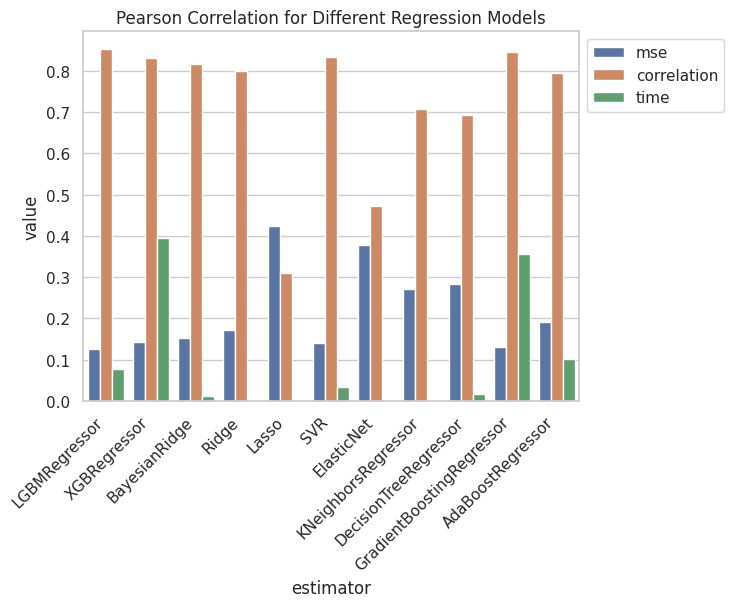

<Figure size 800x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
sns.barplot(results_df, x="estimator", y="value", hue="metric")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Pearson Correlation for Different Regression Models')
plt.xticks(rotation=45,ha="right");
plt.figure(figsize=(8,6))

LGBMRegressor has the highest score. It uses gradient boosting to build decision trees with the best entropy for regression. However SVR, is also performing quite well with much less time than gradient boosting because it uses kernels instead as smoothing functions for regressions. For this reason we try to fine tune SVR to improve its score.

### A Note on Support Vector Machines
Support vector machines are a common technique used for classification and regression. Sometimes, data can be linearly separable. To separate the data we find the **Maximum Margin Hyperplane (MMH)**. This plane creates the greatest separation between the closest observations from all the classes also known as the **support vectors**. The hyperplane is given by: $$w^T⋅x+b=0$$
where $w$ is the weights which determine hyperplane orientation and $b$ is the bias term which determines the shift of the hyperplane.
This can be expressed in terms of an k-dimensional feature space as
$$w_1x_1 + w_2x_2+ \dots + w_kx_k+b=0$$
This typically involves picking two parallel planes and minimizing the distance between them as much as possible to find the hyperplane. The two planes are defined as:
$$w^T⋅x+b\geq1$$
$$w^T⋅x+b\leq-1$$
The goal is to place all observations from one class above the first plane and the other class below the second plane. To maximize the distance between the hyperplanes we need to minimize their Euclidean norm given by $\frac{2}{||w||}$ subject to: $$y_i(w^T⋅x + b)\geq 1\hspace{.5cm}∀~i\in\{1,2…n\}$$
where $y_{i}$ is the label for each sample eg for binary classification $y_{i}=\{-1,1\}$. To find w and b we minimize the **hinge-loss** defined by $$L(w,b) = \sum\limits_{i=1}^n(max(0,1-y_i(w^T⋅x + b)))$$ which maximizes the distance of the hyperplane from the support vectors with minimum error.
This is a primal problem and therefore there exists a corresponding **Lagrangian Dual Problem**. So we can express the problem in terms of Lagrange multipliers:
$$L_D = \sum\limits_{i=1}^nα_i-\frac{1}{2}\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n}α_iα_jy_iy_jx_i \cdot x_j$$
$∀~i,j$ pairs and subject to $α_i>0$ and $\sum\limits_{i=1}^nα_iy_i=0$

Optimizing the function requiers us to set the partial derivatives to zero with respect to the weights and bias.
$$\frac{δ}{δw}:w=\sum\limits_{i=1}^{n}α_iy_ix_i$$
$$\frac{δ}{δb}:0=\sum\limits_{i=1}^{n}α_iy_i$$



Text(0.5, 1.0, 'SVM linear separation in 2 Dimensions')

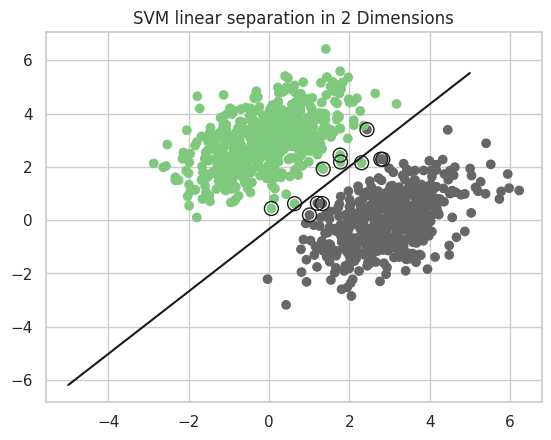

In [ ]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Create some dummy data for two classes
np.random.seed(1)
negatives = np.random.multivariate_normal([3,0],[[1,.5],[.5,1]],500)#pass mean and covariance matrix of the dummy multivariate normal distribution
positives = np.random.multivariate_normal([0,3],[[1,.5],[.5,1]],500)
X = np.r_[negatives,positives]
y = [0]*500 + [1]*500

svc = SVC(kernel='linear')
svc.fit(X, y)

# plot hyperplane by expressing line [w[0],w[1]].[x,y]+b=0 into y=mx+c form.
w = svc.coef_[0]
xx = np.linspace(-5, 5)
yy = -w[0]/w[1] * xx - (svc.intercept_[0])/w[1]

plt.scatter(X[:, 0], X[:, 1], c=y,cmap="Accent_r")

plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k')#apply styling to support vectors
plt.plot(xx, yy, 'k-')

plt.title("SVM linear separation in 2 Dimensions")


The MMH misclassifies one green point and one grey point which are both support vectors. We can make the MMH a non-linear decision boundary by using kernels such as Gaussian/RBF kernels

#### SVM for regression
To perform **Support Vector Regression (SVR)**, we tweak the hinge-loss function to extend to a continous space instead of discete values. This is refered to as the **epsilon-insensitive loss function**.
\begin{equation*}
L(y,f(x)) =
\begin{cases}
  |y - f(x)| - ϵ,\text{if}~|y - f(x)| \gt ϵ\\      
  0,\hspace{2.7cm} \text{if}~|y - f(x)| \le ϵ
\end{cases}
\end{equation*}
where $f(x)$ is the predicted value. If the difference is less than $ϵ$, he error is mapped to zero otherwise the loss increases linearly with the error. SVR constructs a linear regression model $w^T⋅x+b$ and allows for some deviation. The objective function to minimize the loss is given by:
$$min_{w,b}\frac{1}{2}||w||^2+C∑\limits_{i=1}^{n}L(y_i,f(x_i))$$
where ||w|| is the L2 penalty instead of the Euclidean norm and C is the regularization which ensures there is balance between fitting the data and regularazation.
The support vectors that define the margin are given by: $$|y_i - f(x_i)| \lt ϵ~∀~ i \in \{1,2,\dots n\}$$
We use quadratic programming and Lagrange multipliers to find the values of w and b that minimize the objective function.



#### Introducing non-linearity to SVM
To capture non-linear relationships between dependent and independent variables, sometimes it is neccessary to transform a feature space from a low-dimension to a higher-dimension. To do this we need **kernels**. A mapping $K:x_i,x_j → K(x_i,x_j)$ defines a the kernel. Hence our kernelized objective function becomes:
$$min_{w,b,ξ,\xi^*}\frac{1}{2}||w||^2+C\sum\limits_{i=1}^{n}(\xi+\xi^*)$$ subject to $\xi,\xi^*\ge0$. We constrain the errors to the epsilon-insensitive tube and add **slack variables** $\xi,\xi^*$ to allow for small deviation of the margin.
The corresponding dual Lagrangian problem is given by:
$$max_{α,α^*}\sum\limits_{i=1}^{n}\alpha_i^*-\frac{1}{2}\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n}(\alpha_i-\alpha_i^*)K(x_i,x_j)$$
subject to:

$$0\le\alpha_i,\alpha_i^* \le C$$
$$\sum\limits_{i=1}^{n}(\alpha_i-\alpha_i^*)=0$$
where $α_i,α_i^*$ are Lagrange multipliers.

The main kernel functions are:

**Linear** - defined by:
$$K(x_i,x_j) = x_i^Tx_j$$
**Polynomial** - defined by:
$$K(x_i,x_j) = (x_i^Tx_j+c)^d$$
where $c$ is a constant term and $d$ is the degree of the polynomial

**Gaussian/Radial Basis Function (RBF)**-
$$K(x_i,x_j) = e^{-γ||x_{i}-x_{j}||^2}$$
where $||x_{i}-x_{j}||^2$ is the Euclidean distance and the **gamma parameter**, $γ$ controls the scale of similarity i.e the kernel value, and how fast it decreases as the Euclidean distance increases.

**Sigmoid**-
$$K(x_i,x_j) = tanh(γ\cdot x_i^Tx_j+c)$$

#### Tuning Support Vector Regression
Let's try to fine-tune SVR to see if we'll get a better fit. Hyperparameter tuning can be computationally intensive and thus we should choose to fine-tune only parameters that are important. To impose non-linearity, we use rbf as the kernel function.

In [ ]:
def search(params,search_type="random",num=5):
  from itertools import product

  search_combos = list(product(*params.values()))
  search_parameters = [dict(zip(params.keys(), combination)) for combination in search_combos]
  if search_type.lower() == 'grid':
    pass
  else:
    import random
    random.seed(42)
    try:
      search_parameters = random.sample(search_parameters,num)
    except ValueError:
      print("parameter num exceeds search space... using grid")
  params_results = []
  for param_combo in search_parameters:
      params_results.append((param_combo,test_estimators([("SVR",SVR(**param_combo))],False)))

  return params_results


In [ ]:
params = {
      'C': [1, 2,3,4],
      'kernel': ['rbf'],
      'gamma': ["auto","scale"],
      'degree': [1],# degree parameter is only useful to tune in polynomial kernels
      'epsilon': [.001,.01]
  }
results = search(params,'grid')

The scale and auto arguments use $\gamma = \frac{1}{|N|σ^2}$ and $\gamma = \frac{1}{|N|}$ to the rbf function respectively, where |N| is the number of features. You can also set your own default floating-point number as a gamma argument.

In [ ]:
l = sorted([(param_combo,result["SVR"]["correlation"]) for  param_combo,result in results],key=lambda x:x[1],reverse=True)
l[:3]


[({'C': 2, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1, 'epsilon': 0.01},
  0.8496138437184753),
 ({'C': 2, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1, 'epsilon': 0.001},
  0.8495893234617047),
 ({'C': 3, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1, 'epsilon': 0.001},
  0.8487801953987102)]

The grid search gives the best correlation when $C=2$ and $\epsilon=0.001$. We can now train on the full dataset with these hyperparameters.

In [ ]:
predictions = []
estimator = SVR(**{'C': 2, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'epsilon': 0.001})
for y in train_adt:
  estimator.fit(train_rna.T, y.T)
  y_pred = estimator.predict(test_rna.T)
  predictions.append(y_pred)


In [ ]:
predicted_flattened = np.array(predictions).T.flatten()

Now I write the column results to a csv file.

In [ ]:
submission = pd.DataFrame({"ID":[f"ID_{i+1}" for i in range(len(predicted_flattened))], "Expected":predicted_flattened})
submission.to_csv("CIS_678_project2_submission.csv", index=False)